In [143]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats
from scipy.io import loadmat, savemat
from scipy.stats import norm
from scipy.optimize import curve_fit,fmin
from scipy.odr import *

import glob


d= 3e-3
l=8e-3
k=109
k_eff= (np.pi*d**2*k)/(4*l)
p0=1.25

def calfunc(p,x):
    a,b=p
    return a*x+b
def invcalmodel(y,a,b):
    return (y-b)/a +273.15
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def tempvtimerisemodel(p,t):
    tau,T_R,p1=p
    #tau=C_p/K_eff
  
    t2=(p1/k_eff)*(1-np.exp(-t/(tau/k_eff)))+T_R
    return t2
def tempvtimefallmodel(p,t):
    tau,dt,T_R,p1=p
    #tau=C_p/K_eff
    
    
    t2=(p1/k_eff)*(-1+np.exp(-(t-dt)/(tau/k_eff)))+T_R
    return t2
k_eff

0.09630944978661209

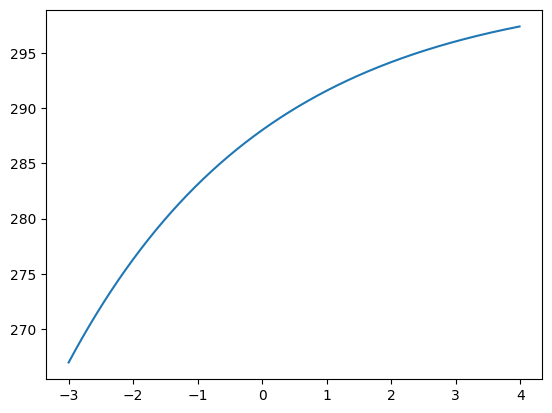

In [131]:
xrange=np.arange(-3,4,.01)
plt.plot(xrange,tempvtimerisemodel([0.3, 288,k_eff,p0],xrange))

Input pulse was a heavside 0 to 5v over 10 s on a 200 ohm resistor'
P= IV=V/R^2=0.125 W=0.125 J/s=> 1.25 J

0.02256808404677765


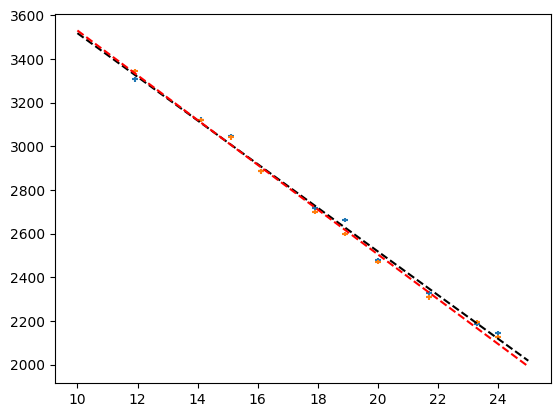

In [123]:
xfine=np.linspace(10,25,1000)
calt= np.array([11.9,14.1,15.1,16.1,17.9,18.9,20,21.7,23.3,24])
calsample=np.array([3306,3122,3048,2888,2715,2661,2480,2326,2188,2144])
calstage=np.array([3345,3120,3040,2885,2699,2598,2469,2308,2196,2127])

#plt.plot(calt,calsample,"k.")
plt.errorbar(calt,calsample,xerr=.1,yerr=10,fmt=" ")
#plt.plot(calt,calstage,"r.")
plt.errorbar(calt,calstage,xerr=.1,yerr=10,fmt=' ')
calmodel=Model(calfunc)
sampledata= RealData(calt,calsample,sx=.1,sy=10)
stagedata=RealData(calt,calstage,sx=.1,sy=10)

sampleodr=ODR(sampledata,calmodel,beta0=[1,1])
stageodr=ODR(stagedata,calmodel,beta0=[1,1])

sampleout=sampleodr.run()
stageout=stageodr.run()


#sampleout.pprint()
#stageout.pprint()
plt.plot(xfine,calfunc(x=xfine,p= sampleout.beta),"--k")
plt.plot(xfine,calfunc(x=xfine,p= stageout.beta),"--r")
calp1=sampleout.beta
temperror=1/np.sqrt(np.sum(sampleout.sd_beta**2))
#plt.plot([10,15,20],[3675,2981,2434],".")
print(temperror)

In [124]:
test7_27=[]
filenames=glob.glob('test8_*.mat')
for i in filenames:
    test7_27.append(loadmat(i))
test7_27[0].keys()


dict_keys(['__header__', '__version__', '__globals__', 'STs', 'Ts', 'pulsetime', 'target', 'ts'])

Beta: [   2.46662965 -205.73522421 1136.16478231   81.35441321]
Beta Std Error: [8.45583228e-03 6.87660500e+01 2.26797528e+03 2.18427449e+02]
Beta Covariance: [[ 2.46698203e-02 -1.17108177e+00 -3.50657459e+01 -3.37712913e+00]
 [-1.17108177e+00  1.63155389e+06 -5.38069885e+07 -5.18212142e+06]
 [-3.50657459e+01 -5.38069885e+07  1.77472022e+09  1.70922327e+08]
 [-3.37712913e+00 -5.18212142e+06  1.70922327e+08  1.64614351e+07]]
Residual Variance: 0.002898322668307934
Inverse Condition #: 7.925929101252459e-10
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 3.00000000e-01  2.91459013e+02 -8.24368615e-19]
Beta Std Error: [0.00000000e+00 0.00000000e+00 1.64142313e-19]
Beta Covariance: [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.60176455e-36]]
Residual Variance: 0.01682063616458648
Inverse Condition #: 1.0
Reason(s) for Halting:
  Problem is not full rank at solution
  Sum of squares convergence


(281.4590125283047, 301.6367470652479)

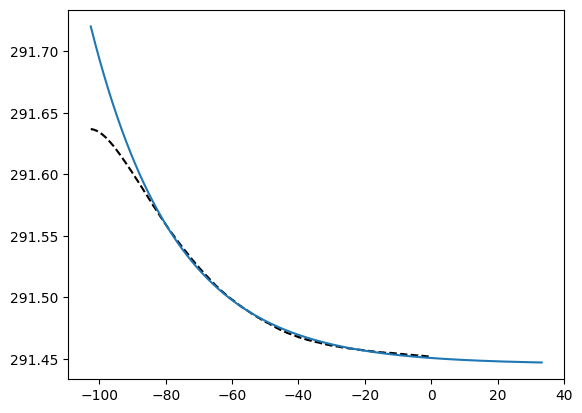

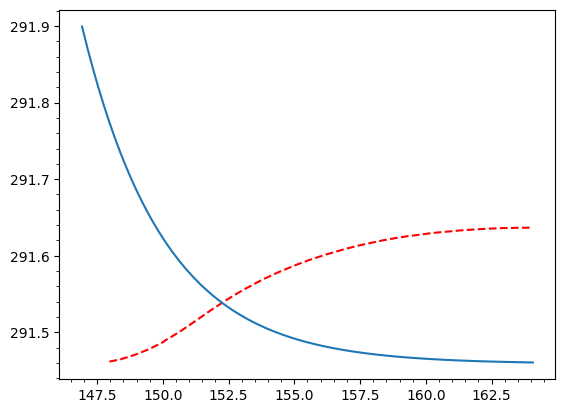

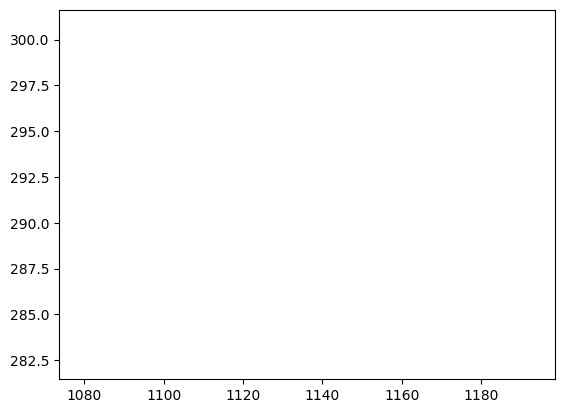

In [157]:
j=6
rplist=[]
rclist=[]
rtaulist=[]

fplist=[]
fclist=[]
ftaulist=[]

plt.figure(0)
modelfall=Model(tempvtimefallmodel)
modelrise=Model(tempvtimerisemodel)

for i in test7_27[j:j+1]:
    
    #some use varbles
    cut=np.where(i['pulsetime'][0][0]==i["ts"][0])[0][0]
    stop=np.where(find_nearest(i["ts"][0],i["ts"][0][cut]+120)==i["ts"][0])[0][0]
    
    maxi=np.where(np.max(invcalmodel(i["STs"][0][cut:stop:],*calp1))==invcalmodel(i["STs"][0][cut:stop:],*calp1))[0][0]
    
    mini=np.where(np.min(invcalmodel(i["STs"][0][cut:stop:],*calp1))==invcalmodel(i["STs"][0][cut:stop:],*calp1))[0][0]
    
    
    
    spline=InterpolatedUnivariateSpline(i["ts"][0][cut+maxi:stop:]-i["ts"][0][cut+maxi],
                  invcalmodel(i["STs"][0][cut+maxi:stop:],*calp1))
    
   
    cut1=cut+np.where(spline(i["ts"][0][cut+maxi:stop:]-i["ts"][0][cut+maxi],nu=1)==
                     np.min(spline(i["ts"][0][cut+maxi:stop:]-i["ts"][0][cut+maxi],nu=1)))[0][0]
    #plt.plot(i["ts"][0][cut1+maxi:stop:]-i["ts"][0][cut+maxi],spline(i["ts"][0][cut1+maxi:stop:]-i["ts"][0][cut+maxi]),".")
    
    
    fdata=RealData(i["ts"][0][cut1+maxi:stop:]-i["ts"][0][cut+maxi],
                  invcalmodel(i["STs"][0][cut1+maxi:stop:],*calp1),sy=temperror)
    mint=np.min(invcalmodel(i["STs"][0][cut:cut+maxi:],*calp1))
    maxt=np.max(invcalmodel(i["STs"][0][cut:cut+maxi:],*calp1))
    min1t=np.min(spline(i["ts"][0][cut1+maxi:stop:]-i["ts"][0][cut+maxi]))
    
    plt.plot(i["ts"][0][cut+maxi:stop:]-i["ts"][0][cut+mini],
                  invcalmodel(i["STs"][0][cut+maxi:stop:],*calp1),"k--")
   
    fodr=ODR(fdata,modelfall,beta0=[0.3,80,mint,p0])
    fout=fodr.run()

    plt.plot(i["ts"][0][cut+maxi::]-i["ts"][0][cut+mini],
             tempvtimefallmodel(p=fout.beta,t=i["ts"][0][cut+maxi::]-i["ts"][0][cut+maxi]))
    fplist.append(fout.beta)
    fclist.append(fout.sd_beta)
    ftaulist.append([fout.beta[0],mint,fout.beta[2],maxt-mint])
    fout.pprint()
    
    #Rise
    plt.figure(1)
    rdata=RealData(i["ts"][0][cut+30:cut+maxi:]-i["ts"][0][cut+mini],
                  invcalmodel(i["STs"][0][cut+30:cut+maxi:],*calp1),
                   )
    rodr=ODR(rdata,modelrise,beta0=[0.3,mint,p0])
    rout=rodr.run()
    
    
    
    plt.plot(i["ts"][0][cut+10:cut+maxi:],
                  invcalmodel(i["STs"][0][cut+10:cut+maxi:],*calp1),"r--")
    
    plt.plot(i["ts"][0][cut:cut+maxi:] ,
             tempvtimerisemodel(p=rout.beta,t=i["ts"][0][cut:cut+maxi:]-i["ts"][0][cut+mini]))
    rplist.append(rout.beta)
    rclist.append(rout.sd_beta)
    rtaulist.append([rout.beta[0],mint,rout.beta[1],maxt-mint])
    
    rout.pprint()
   # plt.ylim(invcalmodel(i["STs"][0][cut:stop:],*calp1)[mini],invcalmodel(i["STs"][0][cut:stop:],*calp1)[maxi])
plt.minorticks_on() 
plt.figure(1)

plt.figure(2)
ftaulist=np.array(ftaulist).T
plt.plot(ftaulist[2],ftaulist[0],".")
rtaulist=np.array(rtaulist).T
#plt.plot(rtaulist[2],rtaulist[0],".")
#plt.plot(hlist[::][0],plist[::][0],".")
plt.ylim(mint-10,maxt+10)

In [89]:
np.array(plist).T[0]

NameError: name 'plist' is not defined

(1120.0, 1290.0)

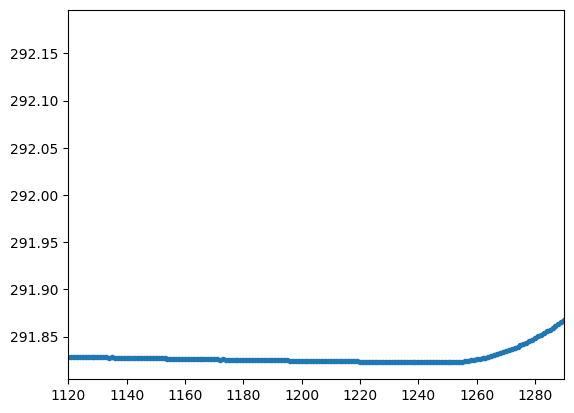

In [593]:
plt.plot(invcalmodel(i["STs"][0][1::],*calp1),".")
plt.xlim(1120,1290)

In [585]:
td["ts"][0][1040]

107.70867549999994

In [586]:
td['pulsetime'][0]

array([122.0374468, 129.3442451,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ])

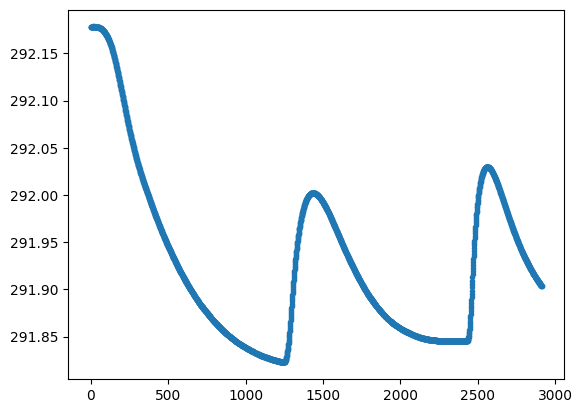

In [592]:
plt.plot(invcalmodel(i["STs"][0][1::],*calp1),".")

In [456]:
td['pulsetime'][0][0]

282.67625300000003

In [455]:
np.where(td['pulsetime'][0][0]==td["ts"][0])[0][0]

2740

In [427]:
find_nearest(i["ts"][0],cut+120)

300.0837551999997